## 2D-histograms

In this notebook we explore the relationship between some of the variables that will be use in the classification.

In [1]:
import glob
import os
import pyart
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# suppress anoying iypthon warnings. Not ideal since we suppress also potentially relevant warnings
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/exts-ml2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Auxiliary functions

In [3]:
# Function to read original dataset
# data is stored as (nz, ny, nx), we return (nx, ny)
def read_nc(fname):
    sat_grid = pyart.io.read_grid(fname)
    for field_name in sat_grid.fields.keys():
        data = np.transpose(np.squeeze(sat_grid.fields[field_name]['data']))
    return data        

In [4]:
def compute_2d_hist(xfield, yfield, xvmin, yvmin, xvmax, yvmax, xstep, ystep):
    # get bins of x field
    xbin_edges = np.linspace(xvmin-xstep/2., xvmax+xstep/2., num=int((xvmax-xvmin)/xstep)+2)
    xstep_aux = xbin_edges[1]-xbin_edges[0]
    xbin_centers = xbin_edges[:-1]+xstep_aux/2.
    
    # get bins of y field
    ybin_edges = np.linspace(yvmin-ystep/2., yvmax+ystep/2., num=int((yvmax-yvmin)/ystep)+2)
    ystep_aux = ybin_edges[1]-ybin_edges[0]
    ybin_centers = ybin_edges[:-1]+ystep_aux/2.    

    # data off limits is put at the bins in the extrems
    xfield[xfield < xbin_centers[0]] = xbin_centers[0]
    xfield[xfield > xbin_centers[-1]] = xbin_centers[-1]

    yfield[yfield < ybin_centers[0]] = ybin_centers[0]
    yfield[yfield > ybin_centers[-1]] = ybin_centers[-1]
    
    return np.histogram2d(xfield, yfield, bins=[xbin_edges, ybin_edges])

In [5]:
def add_2d_hist(fbasepath, xfeature, yfeature, xvmin, yvmin, xvmax, yvmax, xstep, ystep, target=None, target_filter=None):
    xflist = glob.glob(fbasepath+'*/NETCDF/'+xfeature+'/'+'*.nc')
    if len(xflist) == 0:
        return None
    xflist.sort()
    
    hist_2d = None
    for xfname in xflist:
        # Get time step
        bfile = os.path.basename(xfname)
        dt_str = bfile[0:14]
        print(dt_str, end="\r", flush=True)
        
        # get y feature and target file names
        yflist = glob.glob(fbasepath+'*/NETCDF/'+yfeature+'/'+dt_str+'*.nc')
        if len(yflist) == 0:
            continue
            
        if target is not None:
            tflist = glob.glob(fbasepath+'*/NETCDF/'+target+'/'+dt_str+'*.nc')
            if len(tflist) == 0:
                continue
            
        # read data
        xdata = read_nc(xfname).flatten()   
        ydata = read_nc(yflist[0]).flatten()
        
        if target_filter is not None:
            tdata = read_nc(tflist[0]).flatten()
            tdata[tdata == 1] = 0
            tdata[tdata == 2] = 1
            
            xdata = xdata[tdata == target_filter]
            ydata = ydata[tdata == target_filter]
            
        if hist_2d is None:
            hist_2d, xbin_edges, ybin_edges = compute_2d_hist(xdata, ydata, xvmin, yvmin, xvmax, yvmax, xstep, ystep)
        else:    
            hist_2d_aux, xbin_edges, ybin_edges = compute_2d_hist(xdata, ydata, xvmin, yvmin, xvmax, yvmax, xstep, ystep)
            hist_2d += hist_2d_aux
    
    return hist_2d, xbin_edges, ybin_edges        

In [6]:
def plot_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=None):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal', 'box')
    hist_2d[hist_2d == 0] = np.NaN
    cax = ax.pcolormesh(xbin_edges, ybin_edges, np.transpose(hist_2d))
    
    ax.set_xlabel(xfeature)
    ax.set_ylabel(yfeature)
    if target_filter is None:
        ax.set_title('All data')
    elif target_filter == 0:
        ax.set_title('No POH90')
    else:
        ax.set_title('POH90')
    cb = fig.colorbar(cax)
    cb.set_label('Number of pixels')
    
    fig.tight_layout()

In [7]:
def save_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=None):
    if target_filter is None:
        lab = 'all_data'
    elif target_filter == 0:
        lab = 'No_POH90'
    else:
        lab = 'POH90'
    
    # Save data into a .npz file
    np.savez(
        '/data/ml_course/05_Capstone_project/hist_'+lab+'_'+xfeature+'-'+yfeature+'.npz',
        hist_2d=hist_2d, xbin_edges=xbin_edges,)

# IR - channel differences scatter plot

In [8]:
fbasepath = '/data/pyrad_products/MSG_ML/'
xfeature = 'IR_108'
yfeature = 'WV_062-IR_108'
target = 'POH90'

xvmin = 200
xvmax = 311
xstep = 1.

yvmin = -78.
yvmax = 9.
ystep = 1.

## All data

In [9]:
hist_2d, xbin_edges, ybin_edges = add_2d_hist(
    fbasepath, xfeature, yfeature, xvmin, yvmin, xvmax, yvmax, xstep, ystep, target=None, target_filter=None)

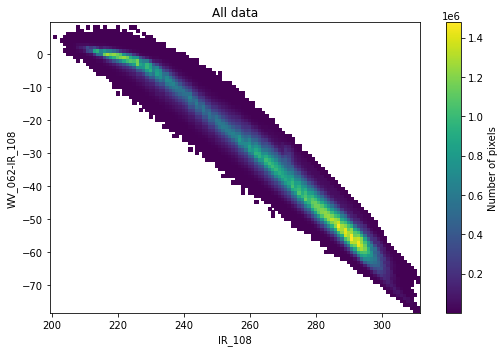

In [10]:
plot_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=None)

In [11]:
save_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=None)

## No hail

In [12]:
hist_2d, xbin_edges, ybin_edges = add_2d_hist(
    fbasepath, xfeature, yfeature, xvmin, yvmin, xvmax, yvmax, xstep, ystep, target=target, target_filter=0)

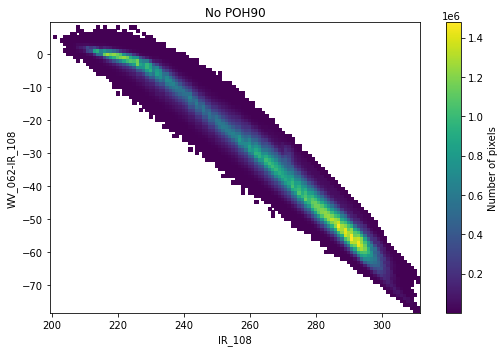

In [13]:
plot_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=0)

In [14]:
save_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=0)

## Hail

In [15]:
hist_2d, xbin_edges, ybin_edges = add_2d_hist(
    fbasepath, xfeature, yfeature, xvmin, yvmin, xvmax, yvmax, xstep, ystep, target=target, target_filter=1)

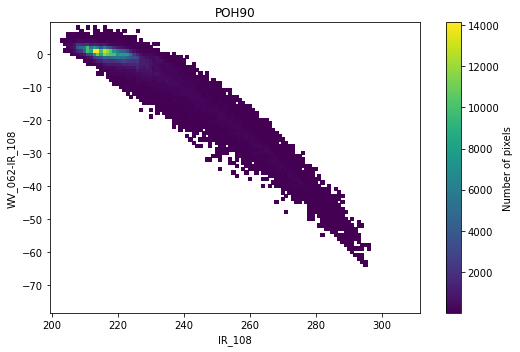

In [16]:
plot_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=1)

In [17]:
save_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=1)

IR_108 and the channel differences are very well correlated. There is a large overlap between non-hail and hail pixels but the concentration of hail pixels is much higher at low IR_108 temperatures and channel differences close to 0.

# IR-HRV_norm scatter plot

In [18]:
fbasepath = '/data/pyrad_products/MSG_ML/'
xfeature = 'IR_108'
yfeature = 'HRV_norm'
target = 'POH90'

xvmin = 200
xvmax = 311
xstep = 1.

yvmin = 0.
yvmax = 100.
ystep = 1.

## All data

In [19]:
hist_2d, xbin_edges, ybin_edges = add_2d_hist(
    fbasepath, xfeature, yfeature, xvmin, yvmin, xvmax, yvmax, xstep, ystep, target=None, target_filter=None)

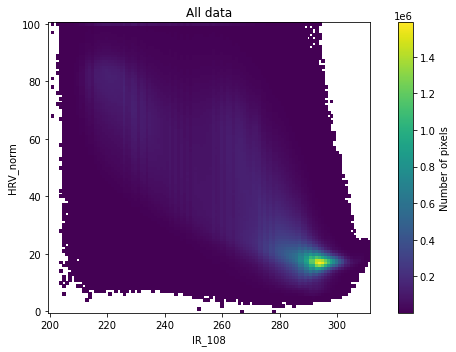

In [20]:
plot_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=None)

In [21]:
save_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=None)

## No hail

In [22]:
hist_2d, xbin_edges, ybin_edges = add_2d_hist(
    fbasepath, xfeature, yfeature, xvmin, yvmin, xvmax, yvmax, xstep, ystep, target=target, target_filter=0)

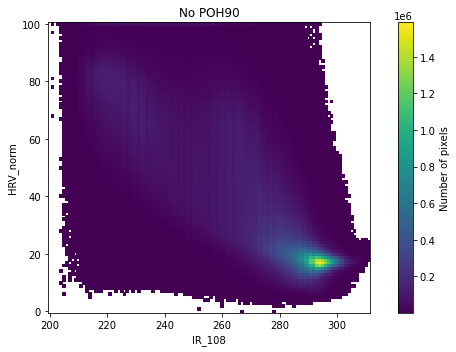

In [23]:
plot_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=0)

In [24]:
save_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=0)

## Hail

In [25]:
hist_2d, xbin_edges, ybin_edges = add_2d_hist(
    fbasepath, xfeature, yfeature, xvmin, yvmin, xvmax, yvmax, xstep, ystep, target=target, target_filter=1)

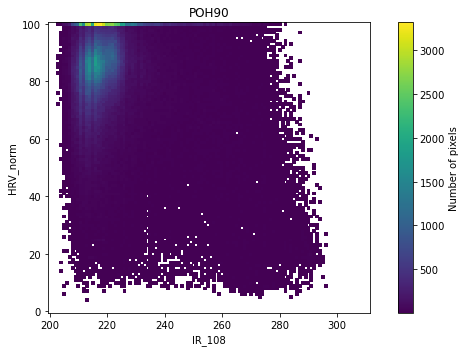

In [26]:
plot_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=1)

In [27]:
save_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=1)

IR_108 and the normalized HRV channels are poorly correlated. Although data is spread almost all over the variable space there are significant differences between the distribution of hail and non-hail pixels. Hail pixels tend to have a larger reflectance and low temperature whereas non-hail pixels are more concentrated in areas of low reflectance and high temperature.

# Channel differences-HRV_norm scatter plot

In [28]:
fbasepath = '/data/pyrad_products/MSG_ML/'
xfeature = 'WV_062-IR_108'
yfeature = 'HRV_norm'
target = 'POH90'

xvmin = -78.
xvmax = 9.
xstep = 1.

yvmin = 0.
yvmax = 100.
ystep = 1.

## All data

In [29]:
hist_2d, xbin_edges, ybin_edges = add_2d_hist(
    fbasepath, xfeature, yfeature, xvmin, yvmin, xvmax, yvmax, xstep, ystep, target=None, target_filter=None)

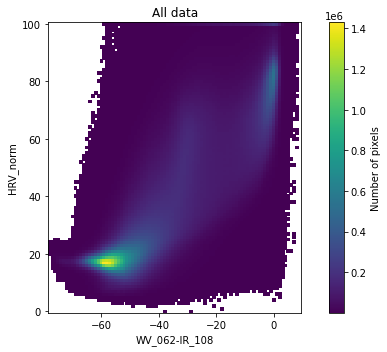

In [30]:
plot_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=None)

In [31]:
save_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=None)

## No hail

In [32]:
hist_2d, xbin_edges, ybin_edges = add_2d_hist(
    fbasepath, xfeature, yfeature, xvmin, yvmin, xvmax, yvmax, xstep, ystep, target=target, target_filter=0)

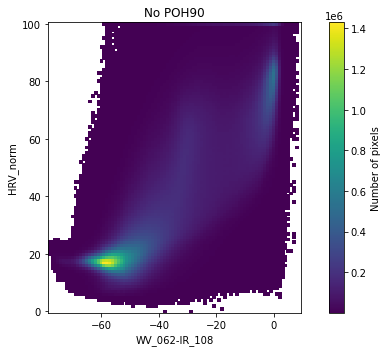

In [33]:
plot_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=0)

In [34]:
save_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=0)

## Hail

In [35]:
hist_2d, xbin_edges, ybin_edges = add_2d_hist(
    fbasepath, xfeature, yfeature, xvmin, yvmin, xvmax, yvmax, xstep, ystep, target=target, target_filter=1)

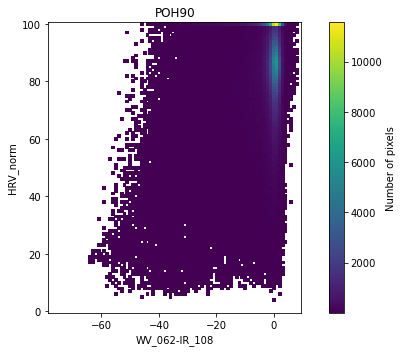

In [36]:
plot_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=1)

In [37]:
save_2d_hist(hist_2d, xbin_edges, ybin_edges, xfeature, yfeature, target_filter=1)

There are significant differences between hail and non-hail pixels when looking at the variable space formed by the channel differences and the normalize HRV. Non hail pixels tend to have very negative values of channel differences and low values of HRV whereas for hail pixels the contrary occurs.

Overall, it can be said that although there is a significant overlap, distinguishable signatures can be observed between hail and non-hail pixels. Therefore we can expect a moderate success of the models